### Simple input LIF_rp_v_input model with integer values only

In [1]:
import sys
#sys.path.append('/home/jovyan/brian2lava')
#sys.path.append('/home/carlo/Entwicklung/Python/brian2lava')
#sys.path.append('/home/francesco/Developing/B2L/brian2lava')
#sys.path.append('/homes/jlubo/brian2lava')

In [2]:
from brian2 import *

In [3]:
# Import Brian2Lava
import brian2lava

# Use included models directory
# models_dir=None

# Use external models directory (containing ncProcessModels for Loihi)
models_dir='/homes/jlubo/brian2lava-models/models'
#models_dir='/homes/francesco.negri/B2L/brian2lava-models/models'

# Use external processes library (for Lava-Loihi/Loihi 2 hardware)
lava_proc_dir = "/homes/jlubo/brian2lava-models/lava_proc"

# Set device, choosing Loihi 2 with fixed-point representation, but switching off F2F conversion
set_device('lava', mode='preset', hardware='Loihi2', num_repr='fixed', use_f2f=False, models_dir=models_dir, lava_proc_dir=lava_proc_dir, variable_updating_disabled=False)
BrianLogger.log_level_debug()

WARNING    The name of one (or more) models defined in the given model directory '/homes/jlubo/brian2lava-models/models' already exists in Brian2Lava's standard model library. Note that user-defined models will always override standard models. If you do not want this to happen, rename your model folder(s). [brian2lava.preset_mode.model_loader]


In [4]:
# Import LIF model with refractory period and voltage input
from brian2lava.preset_mode.model_loader import lif_rp_v_input

In [5]:
# Set scaling factor for fixed-point computation
scf = 1000

# Set seed
seed(1)

# Set defaultclock
defaultclock.dt = 1 * scf * ms

In [6]:
print(lif_rp_v_input.equations, type(lif_rp_v_input.equations))
print(lif_rp_v_input.conditions)

dv/dt = (-v + v_psp + bias)/tau_v : V (unless refractory)
dv_psp/dt = -v_psp/tau_psp : V
bias : V <class 'brian2.equations.equations.Equations'>
{'th': 'v > v_th', 'rs': 'v = v_rs'}


Model name (name of the Lava process)                                           
--------------------------------------------------------------------------------
lif_rp_v_input                                                                  


Description                                                                     
--------------------------------------------------------------------------------
Leaky Integrate-and-Fire neuron with refractory period and exponentially decaying voltage input


Model equations (rendered LaTeX)                                                
--------------------------------------------------------------------------------


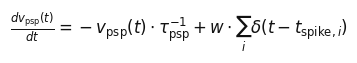

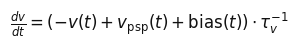

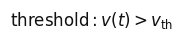

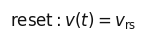



Brian 2 equations                                                               
--------------------------------------------------------------------------------
dv_psp/dt = -v_psp/tau_psp : volt                                               
dv/dt = (-v + v_psp + bias)/tau_v : volt (unless refractory)                    
bias : volt                                                                     


Brian 2 conditions                                                              
--------------------------------------------------------------------------------
th : v > v_th                                                                   
rs : v = v_rs                                                                   


Refractory period                                                               
--------------------------------------------------------------------------------
<supported>


Variables                                                                       
--------

In [7]:
lif_rp_v_input.show()

In [8]:
# Define parameters
N = 3
tau_psp = 4 * scf * ms # delta_psp = dt / tau_psp * 2**12
tau_v = 8 * scf * ms # delta_v = dt / tau_v * 2**12
v_th = 100 * scf * mV
v_rs = 5 * scf * mV
t_rp = 2 * scf * ms

# Add a spike generator group
S = SpikeGeneratorGroup(N, [0, 0], [5, 10]*second) # <--- only works with N neurons!

# Add a neuron group (which has a PSP at the start)
P = NeuronGroup(N, lif_rp_v_input.equations, threshold=lif_rp_v_input.conditions["th"], reset=lif_rp_v_input.conditions["rs"], refractory='t_rp', method='euler')
#P.v_psp = "80 * scf * mV"
P.bias = "14 * scf * mV"
P.v = "2 * scf * mV"

# Add another neuron group (which does not have a PSP at the start but receives spiking input)
Q = NeuronGroup(N, lif_rp_v_input.equations, threshold=lif_rp_v_input.conditions["th"], reset=lif_rp_v_input.conditions["rs"], refractory='t_rp', method='euler')
#Q.v_psp = "0.1*mV"
Q.bias = "0 * scf * mV"
Q.v = "2 * scf * mV"

# Add synapses
syn = Synapses(S, Q, model = 'w : volt', on_pre='v_psp += w')
syn.connect(i=[0], j=[0,1,2])
syn.w = 50 * scf * mV

DEBUG      Creating synapses from group 'spikegeneratorgroup' to group 'neurongroup_1', using pre-defined arrays) [brian2.synapses.synapses]


In [9]:
device = get_device()
device.code_object_class()

brian2.codegen.runtime.numpy_rt.numpy_rt.NumpyCodeObject

In [10]:
# Add monitor for spikes
spmP = SpikeMonitor(P, variables='v', record=True)
spmQ = SpikeMonitor(Q, variables='v', record=True)

# Add monitors for voltage and current
stmPv = StateMonitor(P, variables='v', record=True)
stmPv_psp = StateMonitor(P, variables='v_psp', record=True)
stmQv = StateMonitor(Q, variables='v', record=True)
stmQv_psp = StateMonitor(Q, variables='v_psp', record=True)
# spkmP = SpikeMonitor(P)

DEBUG      Monitor '_spike_spikemonitor' for variable 'v' not added yet, will add the additional var monitor for 'v' later. [brian2.devices.lava]
DEBUG      Monitor '_spike_spikemonitor_1' for variable 'v' not added yet, will add the additional var monitor for 'v' later. [brian2.devices.lava]


In [11]:
# Run simulation
#run(15*ms)
run(30 * second)

DEBUG      Updated MagicNetwork to include 17 objects with names statemonitor_2, spikemonitor, neurongroup_1_stateupdater, neurongroup_spike_thresholder, spikemonitor_1, spikegeneratorgroup, neurongroup_1, statemonitor_1, synapses, neurongroup_spike_resetter, synapses_pre, neurongroup_stateupdater, statemonitor, neurongroup, neurongroup_1_spike_resetter, statemonitor_3, neurongroup_1_spike_thresholder [brian2.core.magic.magic_objects]
DEBUG      Preparing network 'magicnetwork' with 17 objects: neurongroup, neurongroup_1, statemonitor, statemonitor_1, statemonitor_2, statemonitor_3, synapses, neurongroup_1_stateupdater, neurongroup_stateupdater, neurongroup_1_spike_thresholder, neurongroup_spike_thresholder, spikegeneratorgroup, spikemonitor, spikemonitor_1, synapses_pre, neurongroup_1_spike_resetter, neurongroup_spike_resetter [brian2.core.network.before_run]
DEBUG      Group neurongroup_1: using numerical integration method euler (took 0.02s) [brian2.stateupdaters.base.method_choice]

ucode_neuron cmd='/homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/ucode_compiler/bin/dend_asm /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup_1.cpp /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup_1.ucb > /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup_1.dat 2> /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup_1.err'


DEBUG      self.indices = [0 1 2] [brian2.devices.lava]
DEBUG      Added program with index 0 on nx core 2052, processor core 405, group 0... [brian2.devices.lava]
DEBUG      Added program with index 1 on nx core 2052, processor core 405, group 0... [brian2.devices.lava]
DEBUG      Added program with index 2 on nx core 2052, processor core 405, group 0... [brian2.devices.lava]
DEBUG      Saved spike series to /homes/jlubo/brian2lava-models/models/lava_workspace/_spike_spikemonitor_1_spikes_series.npy [brian2.devices.lava]
DEBUG      Running process: neurongroup, <class 'lava_workspace.Loihi2_preset_neurongroup.LIF_rp_v_input'> [brian2.devices.lava]
DEBUG      Process 'neurongroup' initialized with NcL2ModelLif process model [brian2.devices.lava]


ucode_neuron cmd='/homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/ucode_compiler/bin/dend_asm /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.cpp /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.ucb > /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.dat 2> /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.err'


DEBUG      self.indices = [0 1 2] [brian2.devices.lava]
DEBUG      Added program with index 0 on nx core 2052, processor core 405, group 0... [brian2.devices.lava]
DEBUG      Added program with index 1 on nx core 2052, processor core 405, group 0... [brian2.devices.lava]
DEBUG      Added program with index 2 on nx core 2052, processor core 405, group 0... [brian2.devices.lava]
DEBUG      Saved spike series to /homes/jlubo/brian2lava-models/models/lava_workspace/_spike_spikemonitor_spikes_series.npy [brian2.devices.lava]
DEBUG      Successfully run simulation [brian2.devices.lava]
INFO       Retrieving monitor values [brian2.devices.lava]
DEBUG      Got data from state probe referring to 'neurongroup.s_out' (N_tot = 3) [brian2.devices.lava]
DEBUG      Retrieving spike series from /homes/jlubo/brian2lava-models/models/lava_workspace/_spike_spikemonitor_spikes_series.npy [brian2.devices.lava]
DEBUG      Got data from state probe referring to 'neurongroup.v' (N_tot = 3) [brian2.devices.lav

In [12]:
print(f"NeuronGroup P, neuron 0:")
print(f"  v(t=0)      =   {stmPv.v[0][0]/scf}")
print(f"  v_psp(t=0)  =   {stmPv_psp.v_psp[0][0]/scf}")
print(f"  v(t=-1)     =   {stmPv.v[0][-1]/scf}")
print(f"  v_psp(t=-1) =   {stmPv_psp.v_psp[0][-1]/scf}")
print(f"  v           =   {P.v[0]/scf}")
print(f"  v_psp       =   {P.v_psp[0]/scf}")
print("NOTE: the last two values have not been updated since the beginning of the simulation (due to 'variable_updating_disabled=True').")
print(f"NeuronGroup Q, neuron 0:")
print(f"  v(t=0)      =   {stmQv.v[0][0]/scf}")
print(f"  v_psp(t=0)  =   {stmQv_psp.v_psp[0][0]/scf}")
print(f"  v(t=-1)     =   {stmQv.v[0][-1]/scf}")
print(f"  v_psp(t=-1) =   {stmQv_psp.v_psp[0][-1]/scf}")
print(f"  v           =   {Q.v[0]/scf}")
print(f"  v_psp       =   {Q.v_psp[0]/scf}")
print("NOTE: the last two values have not been updated since the beginning of the simulation (due to 'variable_updating_disabled=True').")

NeuronGroup P, neuron 0:
  v(t=0)      =   2. mV
  v_psp(t=0)  =   0. V
  v(t=-1)     =   2. mV
  v_psp(t=-1) =   0. V
  v           =   2. mV
  v_psp       =   0. V
NOTE: the last two values have not been updated since the beginning of the simulation (due to 'variable_updating_disabled=True').
NeuronGroup Q, neuron 0:
  v(t=0)      =   2. mV
  v_psp(t=0)  =   0. V
  v(t=-1)     =   0. V
  v_psp(t=-1) =   0. V
  v           =   0. V
  v_psp       =   0. V
NOTE: the last two values have not been updated since the beginning of the simulation (due to 'variable_updating_disabled=True').


In [13]:
spmP.i

<spikemonitor.i: array([], dtype=int64)>

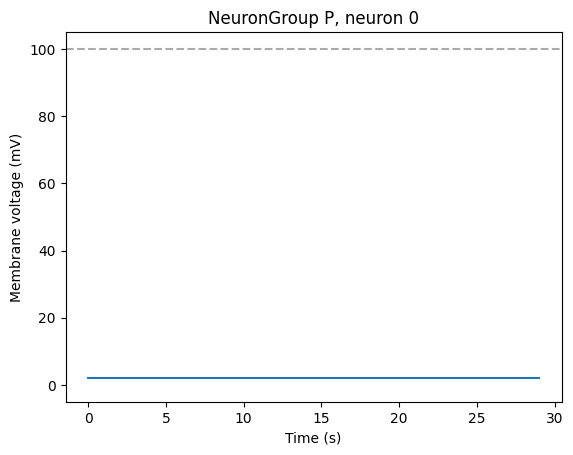

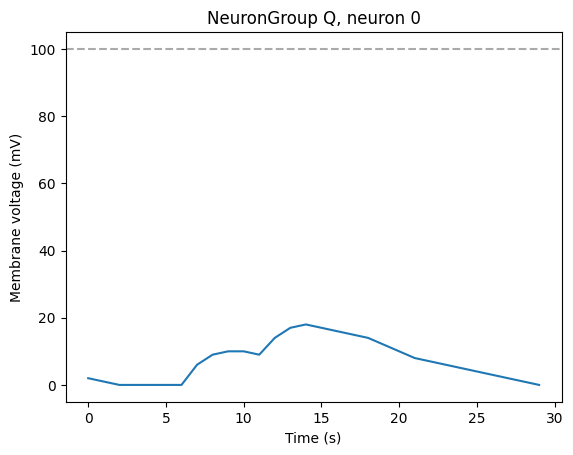

In [14]:
plt.plot(stmPv.t/second,stmPv.v[0]/mV/scf)
plt.axhline(v_th/mV/scf, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup P, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
ylim(-5,105)
show()

plt.plot(stmQv.t/second,stmQv.v[0]/mV/scf)
plt.axhline(v_th/mV/scf, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup Q, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
show()

In [15]:
print("NeuronGroup P:")
print(f"  {len(spmP.i)} spikes occurred in total, {np.sum(spmP.i == 0)} in neuron 0.")
print("  ", spmP.t[spmP.i == 0])
print("  ", spmP.v[spmP.i == 0])
print("NeuronGroup Q:")
print(f"  {len(spmQ.i)} spikes occurred in total, {np.sum(spmQ.i == 0)} in neuron 0.")
print("  ", spmQ.t[spmQ.i == 0])
print("  ", spmQ.v[spmQ.i == 0])

NeuronGroup P:
  0 spikes occurred in total, 0 in neuron 0.
   [] s
   [] V
NeuronGroup Q:
  0 spikes occurred in total, 0 in neuron 0.
   [] s
   [] V
